The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

# Implementation of Multilayer Perceptrons from Scratch

In this notebook, you will learn how to implement a 
multilayer perceptron for classification. 
To compare against our previous results
achieved with the perceptron in the previous tutorial,
we will continue to work with
the Fashion-MNIST image classification dataset.

In [1]:
from d2l import torch as d2l
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

Let's look at a few images from the first batch:

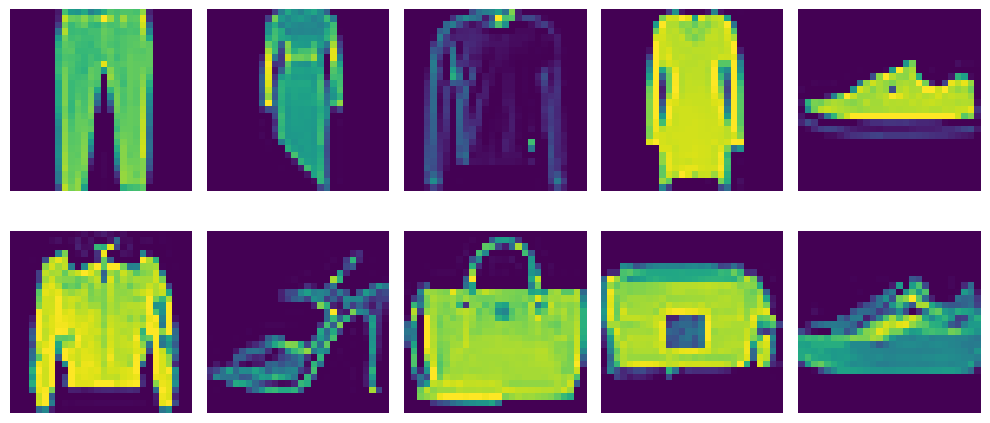

In [3]:
X, y = next(iter(train_iter))


rows, cols = 2,5

plt.figure(figsize=(10,5))
for i in range(rows*cols):
  plt.subplot(rows, cols, i+1)
  img_id = np.random.randint(batch_size)
  plt.imshow(X[img_id,0,:,:])
  plt.axis('off')
plt.tight_layout()
plt.show()


## Initializing Model Parameters

Recall that Fashion-MNIST contains 10 classes,
and that each image consists of a $28 \times 28 = 784$
grid of grayscale pixel values.
Again, we will disregard the spatial structure
among the pixels for now,
so we can think of this as simply a classification dataset
with 784 input features and 10 classes.

To begin, we will implement an MLP
with one hidden layer and 256 hidden units.
Note that we can regard both of these quantities
as hyperparameters.
Typically, we choose layer widths in powers of 2,
which tend to be computationally efficient because
of how memory is allocated and addressed in hardware.

The figure below illustrates the network architecture. The trainable parameters of the network are the weights W1 connecting the input layer with the hidden layer and the weights W2 connecting the hidden layer with the output layer. Note that appart from the weights, the neurons in the hidden and output layers also have a bias, which is not illustrated in the figure. 
<center><img src="https://git.wur.nl/koots006/wias-course-image-and-video-analysis/-/raw/main/day3/classification_network_784_256_10.png" width=400></center>


We will represent our parameters with several tensors.
Note that *for every layer*, we must keep track of
one weight matrix and one bias vector.
As always, we allocate memory
for the gradients of the loss with respect to these parameters.



**Exercise**:
* Calculate by hand how many weights there are in `W1` and `W2`. And how many biases are there for the hidden layer (b1) and the output layer (b2)?
* Run the code below
* Get the size of the tensors `W1`, `b1`, `W2` and `b2` using `W1.shape`, etc
* How many trainable parameters are there in total?
* Check the content of the tensor `W1` using `print(W1)`. What do you see? How are these values determined? Look into the code to see how W1 was determined.

In [4]:
num_inputs, num_outputs, num_hiddens = 784, 10, 256

W1 = nn.Parameter(torch.randn(
    num_inputs, num_hiddens, requires_grad=True) * 0.01)
b1 = nn.Parameter(torch.zeros(num_hiddens, requires_grad=True))
W2 = nn.Parameter(torch.randn(
    num_hiddens, num_outputs, requires_grad=True) * 0.01)
b2 = nn.Parameter(torch.zeros(num_outputs, requires_grad=True))

params = [W1, b1, W2, b2]

In [5]:
## TODO: add code to get the size of the tensors

for x in params:
    print(x.shape)

torch.Size([784, 256])
torch.Size([256])
torch.Size([256, 10])
torch.Size([10])


In [6]:
256 * 728 + 10 * 256 + 10 + 256

189194

## Activation Function

To make sure we know how everything works,
we will implement the ReLU activation ourselves
using the maximum function rather than
invoking the built-in `relu` function directly.


In [7]:
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

**Exercise:**
* Test the `relu` function by adding some code in the block below. You need to provide a torch Tensor as input. For instance: 
`relu(torch.Tensor([-2, 0, 2])`
* Check if the behavior of the activation function is correct, that is, negative values for X should all get an output of 0.0 and positive values for X should just return that value

In [8]:
## TODO: Add code to test the relu function
b = torch.tensor(range(-10, 10), dtype=torch.float32)
relu(b)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

## Model

Using the definition abobe, we will now construt the neural network model for this MLP. A few step that we need to take:

1. The images in the dataset are 28 x 28, but for this MLP, we do not consider the 2D spatial structure of the images, but just use it as a 28x28=784 element input vector, `X`. To get this, we need to `reshape` each two-dimensional image into
a flat vector of length  `num_inputs`.

2. We have to calculate the activation of the neurons in the hidden layer by multiplying the input vector, `X1` with the weights of the first layer `W1`, adding the biases `b1` and applying the relu activation function using<br>
```H = relu(X @ W1 + b1)```, where `@` implements the matrix multiplication.

3. With the activations of the hidden layer, we can calculate the activations of the neurons in the output layer in a similar way, but now without using relu using:<br>
```O = H @ W2 + b2```

The code below implements this network:


In [9]:
def net(X):
    X = X.reshape((-1, num_inputs))
    H = relu(X @ W1 + b1)  # Here '@' stands for matrix multiplication
    O = H @ W2 + b2
    return (O)

To test the function, we can put a few images from the training set as input to observe the output:

In [10]:
X, y = next(iter(train_iter))

img_id = 0
pred = net(X[img_id])

pred

tensor([[ 0.0010, -0.0169,  0.0064, -0.0142,  0.0056, -0.0241, -0.0193,  0.0452,
          0.0136, -0.0153]], grad_fn=<AddBackward0>)

Remember that the output of the networks gives an activation for every class. We can find the class with the maximum activation using `argmax()` and compare it to the ground truth. As this network has not been trained yet and the weights are initialized with random values, this prediction is most likely wrong:

In [11]:
print('Predicted class:',pred.argmax().numpy())
print('True class:',y[0].numpy())

Predicted class: 7
True class: 2


**Exercise:**
* Below, we test and evaluate the untrained MLP. What do you think the accuracy will be?
* Run the code to check it.

The accuracy on the test set is:  0.1001


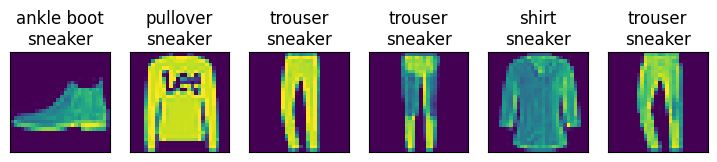

In [12]:
d2l.predict_ch3(net, test_iter)
acc_test = d2l.evaluate_accuracy(net, test_iter)
print("The accuracy on the test set is: ", acc_test)

## Loss Function

Remember that for classification, we need to use cross-entropy loss based on the softmax of the network ouput. To ensure numerical stability,
and because we already implemented
the softmax function from scratch in the previous tutorial,
we use the function `nn.CrossEntropyLoss()` in pyTorch
for calculating the **softmax** and **cross-entropy loss**:

In [13]:
loss = nn.CrossEntropyLoss()

## Training

Fortunately, the training loop for MLPs
is exactly the same as for the perceptron.
Leveraging the `d2l` package again,
we call the `train_ch3` function,
setting the number of epochs to 10
and the learning rate to 0.1.

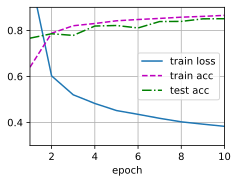

In [14]:
num_epochs, lr = 10, 0.1
updater = torch.optim.SGD(params, lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, updater)

**Exercise:**
* Run the code below to evaluate the learned model on the test data.
* Do you see an improvement over the results you gained yesterday?

The accuracy on the test set is:  0.8507


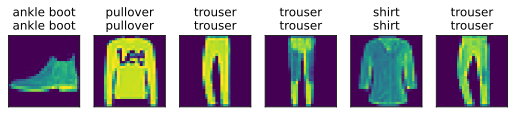

In [15]:
d2l.predict_ch3(net, test_iter)
acc_test = d2l.evaluate_accuracy(net, test_iter)
print("The accuracy on the test set is: ", acc_test)

## Summary

* We saw that implementing a simple MLP is easy, even when done manually.
* However, with a large number of layers, implementing MLPs from scratch can still get messy (e.g., naming and keeping track of our model's parameters).


## Exercises

1. Create two additional networks and compare the results against the current network:
 -  (A) A network without hidden layers (aka the perceptron) (Note that the output layer should not use ReLU)
 -  (B) A network with two hidden layers with in both layers 64 neurons (Note that both hidden layers should use a non-linear activation function such as ReLU)

 NB. You need to change a few things:
  - Set the right model parameters as in the section ***Initializing Model Parameters***
  - Define the network as in the section ***The model***
  - Train the new networks and write down the test loss as in the section  ***Training***
  - Possibly, you need to change the `learning rate` 
 
2. The network that we now used, applied the ReLU activation function to the neurons in the hidden layer.
  - Use `torch.sigmoid()` to build an alternative network that applies the sigmoid function to the neurons in the hidden layer.
  -  Is there a difference in performance or training time?

**NOTE:** While training the network in these exercises you might face an assertion error at the end of the training process pointing that the `train_loss` is larger than 0.5. No worries, there's nothing wrong with your code. It's just that the d2l team decided to put an assertion for the function `train_ch3` that warns you if the loss at the end of the training process is larger than 0.5 (see [source code](https://github.com/d2l-ai/d2l-en/blob/4fce3dfce2cacdb120a8cc5f0dc7e31841833233/d2l/torch.py#L334). To elimitate the error just train again with a slightly larger learning rate.



### Network A

In [20]:
num_inputs, num_outputs = 784, 10

W1 = nn.Parameter(torch.randn(
    num_inputs, num_outputs, requires_grad=True) * 0.01)

b1 = nn.Parameter(torch.zeros(num_outputs, requires_grad=True))

In [21]:
def net(X):
    X = X.reshape((-1, num_inputs))
    O = X @ W1 + b1  # Here '@' stands for matrix multiplication
    return (O)

In [22]:
X, y = next(iter(train_iter))

img_id = 0
pred = net(X[img_id])

pred.shape

torch.Size([1, 10])

In [23]:
pred

tensor([[ 0.0513,  0.1059, -0.0212, -0.0026,  0.0351, -0.0696, -0.0593, -0.0961,
          0.1362, -0.0586]], grad_fn=<AddBackward0>)

AssertionError: 2.3171002671559653

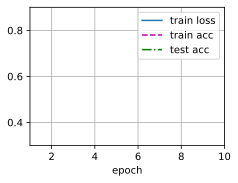

In [25]:
num_epochs, lr = 10, 0.01
updater = torch.optim.SGD(params, lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, updater)